# Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
import missingno as msno
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Datos

In [2]:
ruta = 'df_solares.xlsx'
df = pd.read_excel(ruta, engine='openpyxl')

In [3]:
df.drop(columns={'Hora','Region','Provincia','Comuna','Nombre Propietario','Tecnologia'}, inplace=True)

In [4]:
ruta = 'df_eolicos.xlsx'
dfe = pd.read_excel(ruta, engine='openpyxl')
del ruta

In [5]:
dfe.drop(columns={'Hora','Region','Provincia','Comuna','Nombre Propietario','Tecnologia'}, inplace=True)

## Transformación: Generación potencial

In [131]:
df_edit = df.copy()
# Sumar las columnas 'Real' y 'Vertimiento' para obtener la generación potencial
df_edit['Generacion_Potencial'] = df_edit['Real'].fillna(0) + df_edit['Vertimiento'].fillna(0)
df_edit.drop(columns={'Real','Vertimiento'}, inplace=True)
df_edit

,Nombre,Fecha,Externo,Coordinado,SExperto,Potencia_max_bruta,Generacion_Potencial
0,PFV ALMEYDA,2023-01-01,0.0,0.0,0.0,56.8000,0.0
168019,PFV EL ROMERO,2023-01-01,0.0,0.0,0.0,196.0000,0.0
265135,PFV LALACKAMA II,2023-01-01,0.0,0.0,0.0,16.5000,0.0
176780,PFV FINIS TERRAE,2023-01-01,0.0,0.0,0.0,248.2100,0.0
40853,PFV BOLERO,2023-01-01,0.0,0.0,0.0,138.2000,0.0
...,...,...,...,...,...,...,...
460926,PFV SOL DEL DESIERTO,2024-01-01,NaN,NaN,NaN,230.4800,0.0
230090,PFV LA CRUZ SOLAR,2024-01-01,NaN,NaN,NaN,52.8137,0.0
221329,PFV JAVIERA,2024-01-01,NaN,NaN,NaN,69.0180,0.0
212568,PFV JAMA,2024-01-01,NaN,NaN,NaN,52.6500,0.0


## Valores perdidos (Interpolación)

In [135]:
df_edit.dtypes

Nombre                          object
Fecha                   datetime64[ns]
Externo                        float64
Coordinado                     float64
SExperto                       float64
Potencia_max_bruta             float64
Generacion_Potencial           float64
dtype: object

In [136]:
df_edit.isnull().sum()

Nombre                       0
Fecha                        0
Externo                  78542
Coordinado               93182
SExperto                106004
Potencia_max_bruta           0
Generacion_Potencial         0
dtype: int64

<Axes: >

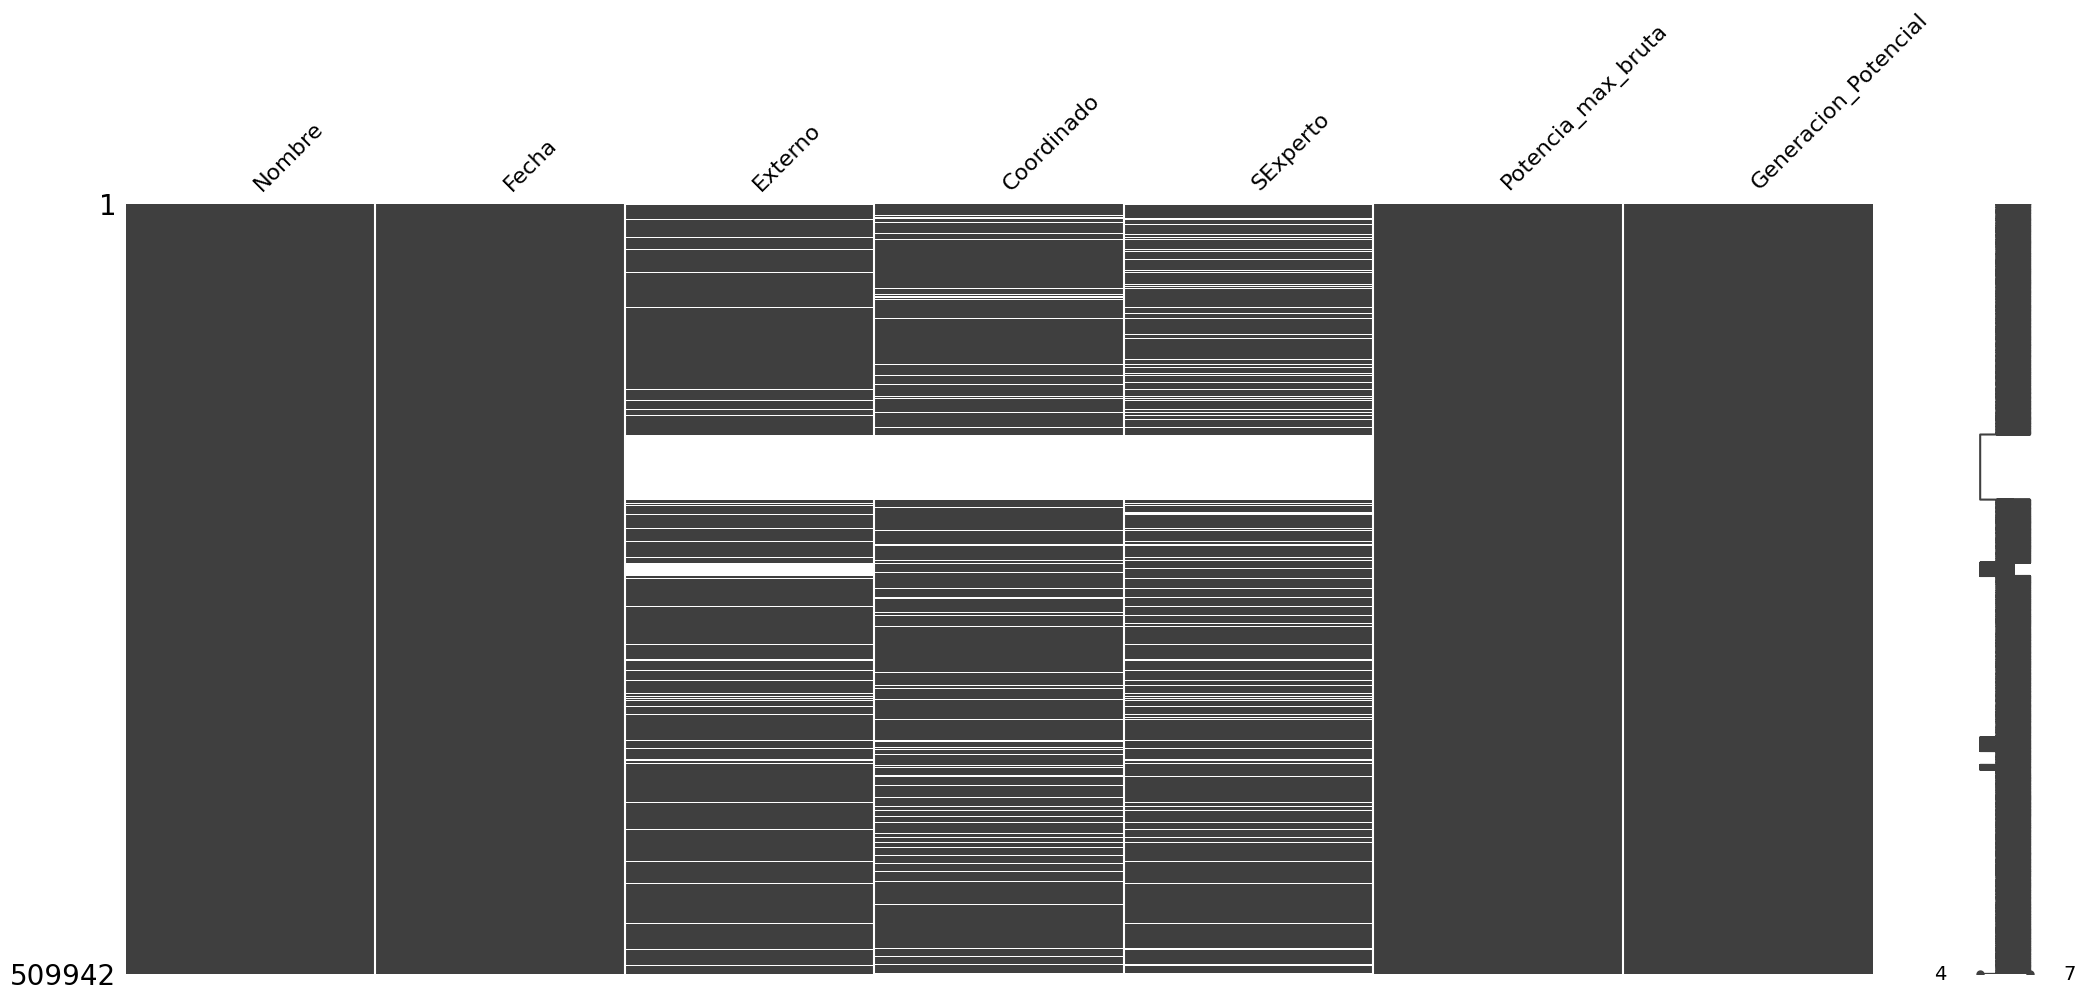

In [137]:
df_edit.sort_values(by='Fecha')
msno.matrix(df_edit)

In [140]:
# Calcular el coeficiente de asimetría
pronosticos = ['Generacion_Potencial', 'Externo', 'Coordinado', 'SExperto']
print(pronosticos)
for i in pronosticos:

  skewness = df_edit[i].skew()
  print(f"Coeficiente de Asimetría: {skewness}")

  # Interpretación del resultado
  if skewness > 0:
      print(f"La distribución de {i} tiene un sesgo positivo (hacia la derecha).")
  elif skewness < 0:
      print(f"La distribución de {i} tiene un sesgo negativo (hacia la izquierda).")
  else:
      print(f"La distribución de {i} es aproximadamente simétrica.")
del skewness, pronosticos, i

['Generacion_Potencial', 'Externo', 'Coordinado', 'SExperto']
Coeficiente de Asimetría: 2.530377799323412
La distribución de Generacion_Potencial tiene un sesgo positivo (hacia la derecha).
Coeficiente de Asimetría: 2.46000702158714
La distribución de Externo tiene un sesgo positivo (hacia la derecha).
Coeficiente de Asimetría: 2.378657226430203
La distribución de Coordinado tiene un sesgo positivo (hacia la derecha).
Coeficiente de Asimetría: 2.26252988146878
La distribución de SExperto tiene un sesgo positivo (hacia la derecha).


In [142]:
# Porcentaje de valores faltantes por columna
porcentaje_faltantes = df_edit.isna().mean() * 100
print(porcentaje_faltantes.sort_values(ascending=False))

SExperto                20.787462
Coordinado              18.273059
Externo                 15.402144
Nombre                   0.000000
Fecha                    0.000000
Potencia_max_bruta       0.000000
Generacion_Potencial     0.000000
dtype: float64


In [144]:
# Conteo de filas con valores faltantes
filas_con_faltantes = df_edit.isna().any(axis=1).sum()
print(f"Número de filas con al menos un valor faltante: {filas_con_faltantes}")
del filas_con_faltantes

Número de filas con al menos un valor faltante: 137660


In [145]:
df_edit = df_edit.sort_values('Fecha')
df_imputado = df_edit.interpolate()

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_15268\283779197.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_imputado = df_edit.interpolate()


In [174]:
# Porcentaje de valores faltantes por columna
porcentaje_faltantes = df_imputado .isna().mean() * 100
print(porcentaje_faltantes.sort_values(ascending=False))
del porcentaje_faltantes

Nombre                  0.0
Fecha                   0.0
Externo                 0.0
Coordinado              0.0
SExperto                0.0
Potencia_max_bruta      0.0
Generacion_Potencial    0.0
dtype: float64


In [175]:
mask = df_imputado.isna().any(axis=1)

# Filtrar el DataFrame para mostrar solo esas filas
df_con_valores_vacios = df_imputado[mask]

print(df_con_valores_vacios['Fecha'].dt.hour.unique())
del df_con_valores_vacios,  mask

[]


In [176]:
df_imputado = df_imputado.fillna(0)

In [177]:
# Porcentaje de valores faltantes por columna
porcentaje_faltantes = df_imputado.isna().mean() * 100
print(porcentaje_faltantes.sort_values(ascending=False))
del porcentaje_faltantes

Nombre                  0.0
Fecha                   0.0
Externo                 0.0
Coordinado              0.0
SExperto                0.0
Potencia_max_bruta      0.0
Generacion_Potencial    0.0
dtype: float64


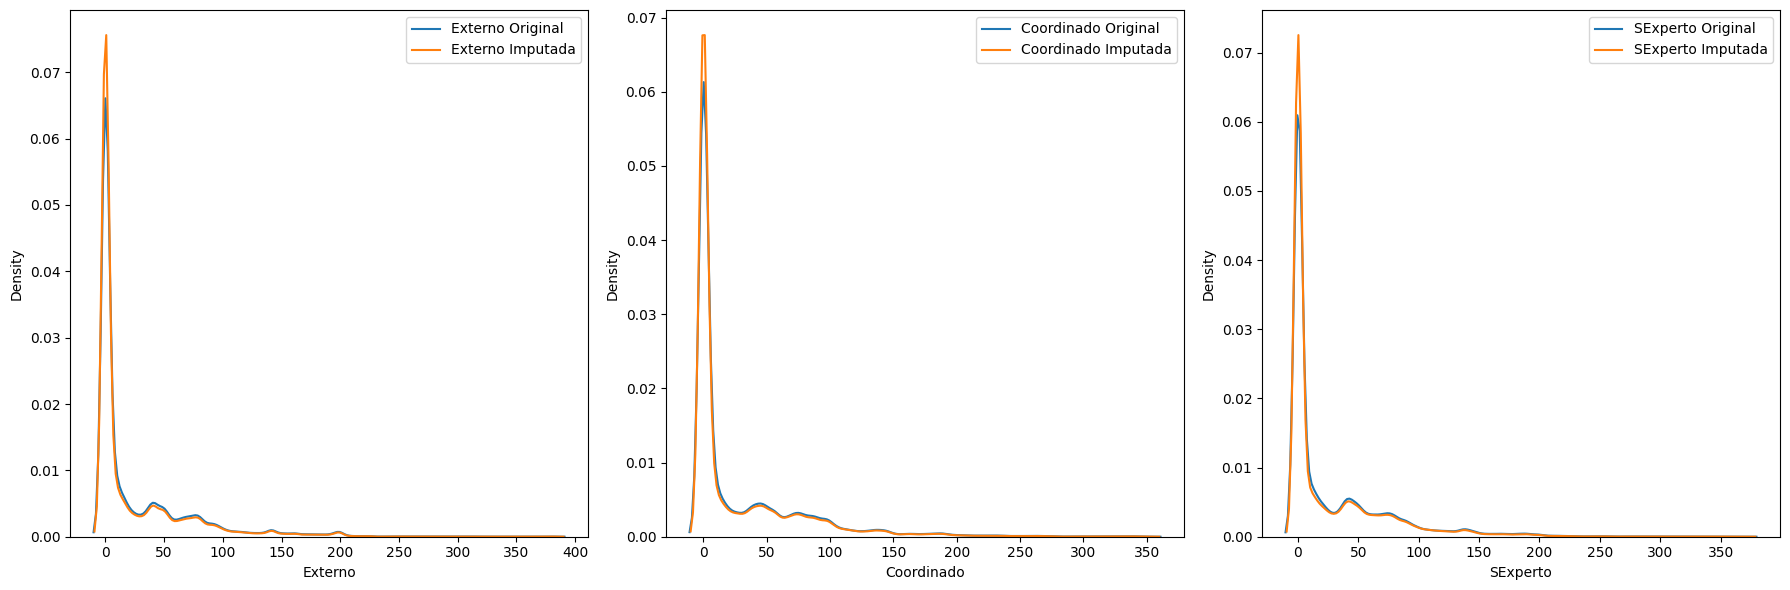

In [152]:
columnas = ['Externo', 'Coordinado', 'SExperto']

plt.figure(figsize=(18, 6))
for i, columna in enumerate(columnas, 1):
    plt.subplot(1, len(columnas), i)
    sn.kdeplot(df_edit[f'{columna}'].dropna(), label=f'{columna} Original')
    sn.kdeplot(df_imputado[f'{columna}'], label=f'{columna} Imputada')
    plt.legend()
plt.tight_layout()
plt.show()
del columnas, i

## Limpieza

### Filtración de centrales con data incompleta

In [178]:
# Cargamos el DataFrame df, que ya debería estar en tu entorno
# Asegúrate de que la columna 'Fecha' esté en formato datetime
df_imputado['Fecha'] = pd.to_datetime(df_imputado['Fecha'])

# Crear una nueva columna 'Mes' extrayendo el año y el mes de la columna 'Fecha'
df_imputado['Mes'] = df_imputado['Fecha'].dt.to_period('M')

# Identificar todas las centrales y todos los meses posibles dentro del rango de fechas
centrales_unicas = df_imputado['Nombre'].unique()
min_fecha = df_imputado['Fecha'].min()
max_fecha = df_imputado['Fecha'].max()
meses_unicos = pd.period_range(start=min_fecha, end=max_fecha, freq='M')

# Crear un DataFrame de resumen con todas las centrales y todos los meses, inicialmente con 1's
df_resumen = pd.DataFrame(1, index=centrales_unicas, columns=meses_unicos)

# Rellenar la tabla con 0's donde hay datos
for central in centrales_unicas:
    datos_central = df_imputado[df_imputado['Nombre'] == central]
    for periodo in datos_central['Mes'].unique():
        df_resumen.at[central, periodo] = 0  # Marcar con 0 si hay datos en ese mes

# Convertir el índice de periodos a cadena para que sea compatible con otros formatos como CSV
df_resumen.columns = df_resumen.columns.astype(str)

# Mostrar el DataFrame resultante
df_resumen.reset_index(inplace=True)
print(df_resumen)

                    index  2023-01  2023-02  2023-03  2023-04  2023-05  \
0             PFV ALMEYDA        0        0        0        0        0   
1   PFV PAMPA SOLAR NORTE        0        0        0        0        0   
2     PFV NUEVO QUILLAGUA        0        0        0        0        0   
3    PFV SOL DE LOS ANDES        0        0        0        0        0   
4        PFV DEL DESIERTO        0        0        0        0        0   
..                    ...      ...      ...      ...      ...      ...   
60     PFV CAMPOS DEL SOL        1        1        1        1        1   
61       PFV SANTA ISABEL        1        1        1        1        1   
62               PFV COYA        1        1        1        1        1   
63      PFV VALLE DEL SOL        1        1        1        1        1   
64           PFV GUANCHOI        1        1        1        1        1   

    2023-06  2023-07  2023-08  2023-09  2023-10  2023-11  2023-12  2024-01  
0         0        0        0     

In [179]:
# Asumiendo que df_resumen ya ha sido creado con tu código base

# Identificar las centrales con al menos un '1' en alguna fecha, lo que indica datos faltantes
centrales_con_datos_faltantes = df_resumen[df_resumen.drop(columns='index').eq(1).any(axis=1)]['index'].tolist()

# Mostrar las centrales con datos faltantes
print("Centrales con series incompletas:", centrales_con_datos_faltantes)
print(len(centrales_con_datos_faltantes))
 


Centrales con series incompletas: ['PFV SALVADOR', 'PFV ANDES SOLAR II', 'PFV AZABACHE', 'PFV DIEGO DE ALMAGRO SUR', 'PFV SOL DE LILA', 'PFV PAMPA TIGRE', 'PFV VALLE ESCONDIDO', 'PFV DOMEYKO', 'PFV CAPRICORNIO', 'PFV CASTILLA', 'PFV MACHICURA', 'PFV TENO SOLAR', 'PFV CAMPOS DEL SOL', 'PFV SANTA ISABEL', 'PFV COYA', 'PFV VALLE DEL SOL', 'PFV GUANCHOI']
17


In [180]:

df_filtrado = df_imputado[~df_imputado['Nombre'].isin(centrales_con_datos_faltantes)]
del df_imputado
# Mostrar el DataFrame filtrado para verificar
df_filtrado.describe(include='all').round(1)
#df.describe(include='all').round(1)

,Nombre,Fecha,Externo,Coordinado,SExperto,Potencia_max_bruta,Generacion_Potencial,Mes
count,420528,420528,420528.0,420528.0,420528.0,420528.0,420528.0,420528
unique,48,NaN,NaN,NaN,NaN,NaN,NaN,13
top,PFV ALMEYDA,NaN,NaN,NaN,NaN,NaN,NaN,2023-01
freq,8761,NaN,NaN,NaN,NaN,NaN,NaN,35712
mean,NaN,2023-07-02 12:00:00,20.5,24.6,23.0,78.2,20.8,NaN
min,NaN,2023-01-01 00:00:00,0.0,0.0,0.0,1.5,0.0,NaN
25%,NaN,2023-04-02 06:00:00,0.0,0.0,0.0,30.7,0.0,NaN
50%,NaN,2023-07-02 12:00:00,0.0,0.0,0.0,68.5,0.3,NaN
75%,NaN,2023-10-01 18:00:00,28.0,38.4,38.0,105.4,29.6,NaN
max,NaN,2024-01-01 00:00:00,247.4,303.3,272.2,248.2,408.3,NaN


### Filtración de horas sin actividad solar

In [181]:
df_filtrado.set_index('Fecha', inplace=True)
df_filtrado['Hora'] = df_filtrado.index.hour
df_filtrado.reset_index(inplace=True)

In [182]:
df_maxima_generacion = df_filtrado.groupby(['Nombre', 'Hora'])['Generacion_Potencial'].max().reset_index()
# Luego, necesitas obtener los valores únicos de 'Potencia_max_bruta' por 'Nombre'
potencia_maxima = df_filtrado.groupby('Nombre')['Potencia_max_bruta'].max().reset_index()

# Finalmente, haces un merge para agregar 'Potencia_max_bruta' a tu df_maxima_generacion
df_maxima_generacion = df_maxima_generacion.merge(potencia_maxima, on='Nombre', how='left')

#dataframe con las horas por central que tienen maxima generación igual 0
#maxGenCero =df_maxima_generacion[df_maxima_generacion['Generacion_Potencial'] == 0 ]
maxGenCero =df_maxima_generacion[df_maxima_generacion['Generacion_Potencial'] <= df_maxima_generacion['Potencia_max_bruta']*0.001 ]
#Eliminamos columna para no obtener una duplicada en el merge
maxGenCero.drop(columns={'Generacion_Potencial'}, inplace=True)
#Hacemos un df con las filas que queremos eliminar
dfEliminar = pd.merge(df_filtrado, maxGenCero, on=['Nombre', 'Hora'], how='inner')

# Asumiendo que df_eliminar contiene las filas a eliminar basadas en 'Nombre' y 'Hora'
# Creamos un identificador único combinando 'Nombre' y 'Hora' para ambas DataFrames
df_filtrado['identificador'] = df_filtrado['Nombre'] + df_filtrado['Fecha'].astype(str)
dfEliminar['identificador'] = dfEliminar['Nombre'] + dfEliminar['Fecha'].astype(str)

# Filtramos df_solares para excluir las filas cuyos identificadores están en df_eliminar
identificadores_para_eliminar = set(dfEliminar['identificador'])
df_limpio = df_filtrado[~df_filtrado['identificador'].isin(identificadores_para_eliminar)]

# Opcional: Puedes eliminar la columna 'identificador' si ya no la necesitas
df_limpio.drop(columns=['identificador', 'Hora', 'Mes'], inplace=True)
del df_maxima_generacion, maxGenCero, identificadores_para_eliminar, dfEliminar, df_filtrado

# Ahora df_solares_limpio contiene solo las filas que no están en df_eliminar


C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_15268\368371353.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maxGenCero.drop(columns={'Generacion_Potencial'}, inplace=True)
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_15268\368371353.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio.drop(columns=['identificador', 'Hora', 'Mes'], inplace=True)


## Variable hora (para dummies)

In [183]:
df_limpio['Hora'] = df_limpio['Fecha'].dt.hour

In [184]:
df_limpio['Hora'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

## Analisis exploratorio

In [212]:
central = 'PFV JAMA'
datos_central = df_limpio[df_limpio['Nombre']== central]

In [76]:
hor4= datos_central[datos_central['Hora'] == 6]

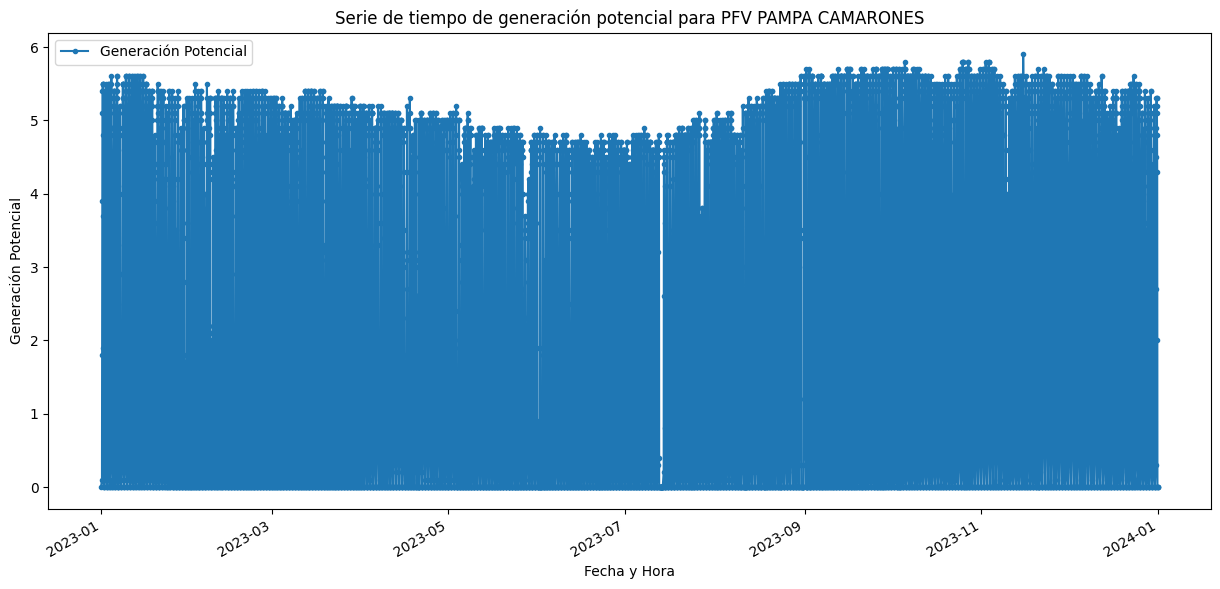

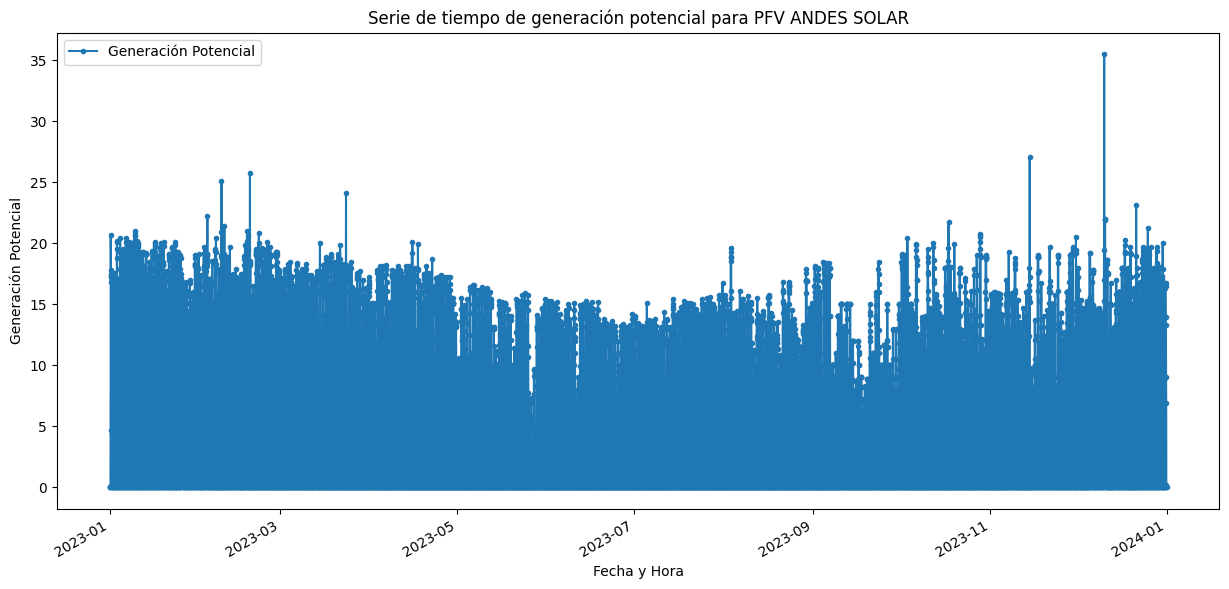

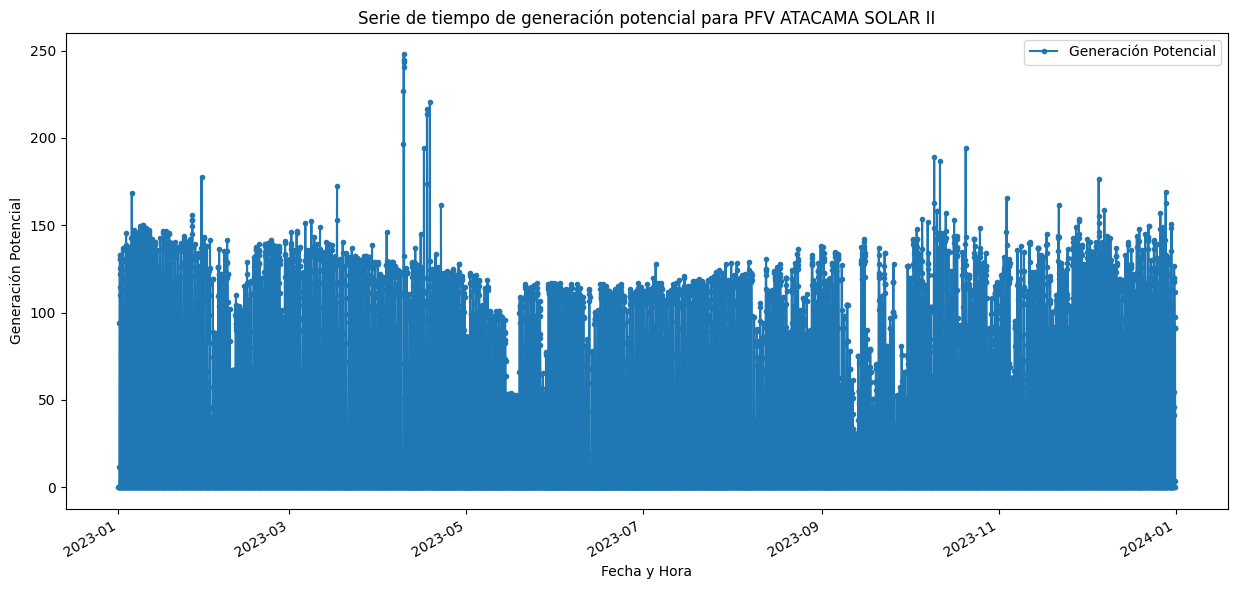

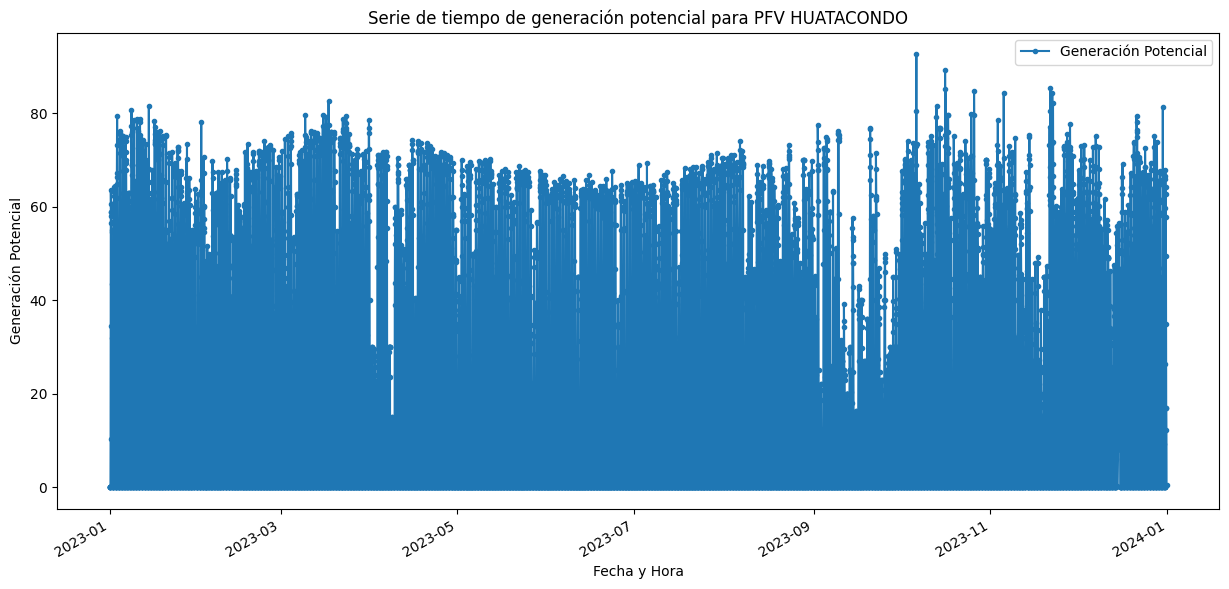

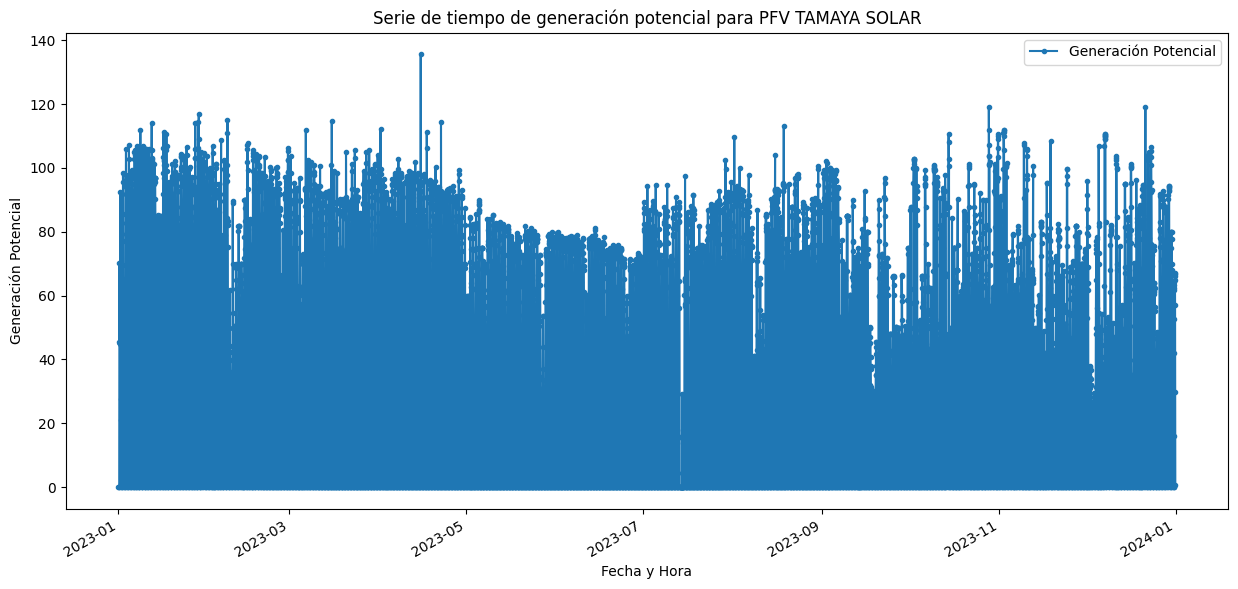

In [213]:
centrales_unicas = df_limpio['Nombre'].unique()[:5]

# Iterar sobre cada central única
for central in centrales_unicas:
    # Filtrar los datos para la central actual
    datos_central = df_limpio[df_limpio['Nombre'] == central]
    
    # Asegurarse de que los datos estén ordenados por fecha
    datos_central = datos_central.sort_values(by='Fecha')
    
    # Crear un nuevo gráfico
    plt.figure(figsize=(15, 7))
    
    # Trazar la serie de tiempo de la generación potencial
    plt.plot(datos_central['Fecha'], datos_central['Generacion_Potencial'], label='Generación Potencial', marker='o', linestyle='-', markersize=3)
    
    # Añadir título y leyenda al gráfico
    plt.title(f"Serie de tiempo de generación potencial para {central}")
    plt.xlabel('Fecha y Hora')
    plt.ylabel('Generación Potencial')
    plt.legend()
    
    # Mejorar el formato de la fecha en el eje x
    plt.gcf().autofmt_xdate()
    
    # Mostrar el gráfico
    plt.show()

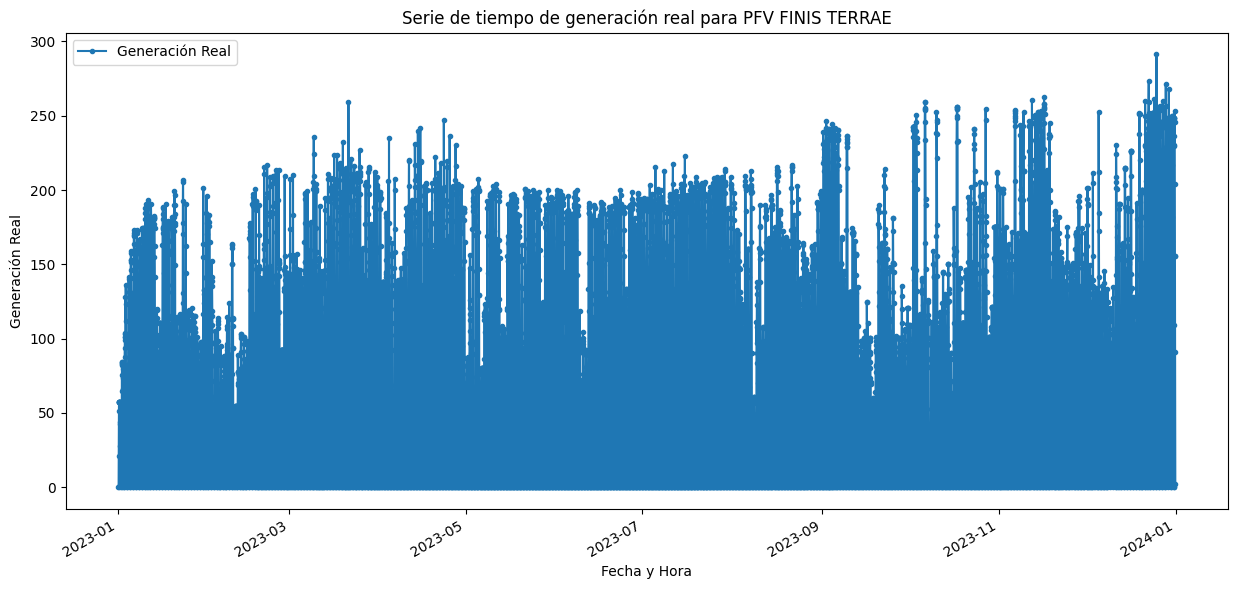

In [251]:
#Filtrar  datos por central
central = 'PFV FINIS TERRAE'
datos_central = df_limpio[df_limpio['Nombre']== central]

# Asegurarse de que los datos estén ordenados por fecha
datos_central = datos_central.sort_values(by='Fecha')

 # Crear un nuevo gráfico
plt.figure(figsize=(15, 7))
    
    # Trazar la serie de tiempo de la generación real
plt.plot(datos_central['Fecha'], datos_central['Generacion_Potencial'], label='Generación Real', marker='o', linestyle='-', markersize=3)

  # Añadir título y leyenda al gráfico
plt.title(f"Serie de tiempo de generación real para {central}")
plt.xlabel('Fecha y Hora')
plt.ylabel('Generación Real')
plt.legend()

# Mejorar el formato de la fecha en el eje x
plt.gcf().autofmt_xdate()

# Mostrar el gráfico
plt.show()




In [218]:
print(len(df_limpio[df_limpio['Nombre']== 'PFV FINIS TERRAE']['Hora'].unique()))
df_limpio[df_limpio['Nombre']== 'PFV FINIS TERRAE']['Hora'].unique()


16


array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

# Regresión

In [267]:
Y = datos_central['Generacion_Potencial']
dummies = pd.get_dummies(datos_central['Hora'], drop_first=True, prefix='h')
dummies = dummies.astype(float)
X = pd.concat([datos_central['Externo'],datos_central['Coordinado'], dummies],axis=1)
X = sm.add_constant(X)

In [247]:
X

,const,Externo,Coordinado,h_9,h_10,h_11,h_12,h_13,h_14,h_15,h_16,h_17,h_18,h_19,h_20
394,1.0,0.4,13.010000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
448,1.0,0.9,32.800000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488,1.0,1.3,92.766667,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
565,1.0,1.6,106.150000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,1.0,1.8,118.505000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420096,1.0,1.4,13.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
420186,1.0,1.0,96.735000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
420193,1.0,0.6,14.990000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
420266,1.0,0.2,21.365000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Sliding window

In [268]:
horas_relevantes = df_limpio[df_limpio['Nombre']== 'PFV FINIS TERRAE']['Hora'].unique()
horas_relevantes

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

In [269]:
# Dividir el DataFrame filtrado en entrenamiento y prueba
num_dias_entrenamiento = 120
filas_por_dia = len(horas_relevantes)
# Calcular el número de días en el DataFrame
dias_totales = len(X) // filas_por_dia
print(dias_totales)
# Multiplica por la cantidad de horas relevantes por día para obtener el punto de corte
punto_corte = num_dias_entrenamiento * len(horas_relevantes)
# Crear un DataFrame vacío para almacenar las predicciones
predicciones_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar los parámetros estimados
parametros_df = pd.DataFrame()
potencia_maxima = datos_central['Potencia_max_bruta'].max()


365


In [270]:

# Agregamos Interacciones a la variabl X
var_ind = ['Externo', 'Coordinado']
for var in var_ind:
    for dummie in dummies.columns:
        nombre_interaccion = f'{var}-{dummie}'
        X[nombre_interaccion] = X[var] * X[dummie]

# Inicializar el DataFrame para almacenar los parámetros estimados
parametros_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar las predicciones
predicciones_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar las variables de predicción de cada día
variables_prediccion_df = pd.DataFrame()

# Iterar a través de los días, ajustando el modelo y realizando predicciones
for dia in range(dias_totales - num_dias_entrenamiento):
    # Definir el conjunto de entrenamiento para la ventana actual
    inicio = dia * filas_por_dia
    fin = inicio + num_dias_entrenamiento * filas_por_dia
    X_train = X.iloc[inicio:fin]
    Y_train = Y.iloc[inicio:fin]

    # Ajustar el modelo
    modelo = sm.OLS(Y_train, X_train).fit()

    # Extraer y almacenar los parámetros estimados para la fecha actual
    parametros_actuales = modelo.params
    parametros_df = pd.concat([parametros_df, pd.DataFrame(parametros_actuales).T])

    # Realizar predicciones para el siguiente día
    X_test = X.iloc[fin:fin + filas_por_dia]
    predicciones = modelo.predict(X_test)

    # Aplicar el límite inferior y superior a las predicciones
    predicciones = np.maximum(predicciones, 0)  # Límite inferior, asegurando que la predicción no sea menor que 0
    predicciones = np.minimum(predicciones, potencia_maxima)  # Límite superior

    # Almacenar las predicciones
    predicciones_df = pd.concat([predicciones_df, predicciones])

    # Almacenar las variables utilizadas para la predicción del nuevo día
    variables_prediccion_df = pd.concat([variables_prediccion_df, X_test])

# Restablecer los índices de los DataFrames
parametros_df.reset_index(drop=True, inplace=True)
predicciones_df.reset_index(drop=True, inplace=True)
predicciones_df.rename(columns={0:'pred'},inplace=True)
variables_prediccion_df.reset_index(drop=True, inplace=True)

# Ahora 'parametros_df' contiene los parámetros estimados de cada modelo, 'predicciones_df' las predicciones, 
# y 'variables_prediccion_df' las variables utilizadas para cada predicción.
print(parametros_df)
print(predicciones_df)
print(variables_prediccion_df)

# Eliminación de variables pesadas para optimizar la memoria
del X, X_train, X_test


            const       Externo    Coordinado       h_7        h_8  \
0    1.249840e-11 -7.982154e-10  7.295473e-11 -0.013483 -30.130834   
1    1.870393e-11 -1.920597e-09  2.334500e-10 -0.013058 -26.059572   
2    2.981029e-12 -7.495694e-10  1.219356e-10 -0.012747 -22.321110   
3    1.940295e-11 -2.845508e-09  3.493582e-10 -0.012236 -18.933210   
4    5.481880e-13  2.073170e-10 -3.094189e-11 -0.011961 -16.854196   
..            ...           ...           ...       ...        ...   
240  1.242113e-03  5.941182e-02 -1.024746e-03 -0.052276 -43.402044   
241  1.237092e-03  5.755219e-02 -9.767029e-04 -0.056563 -41.829958   
242  1.232153e-03  5.580092e-02 -9.314206e-04 -0.061526 -41.207031   
243  1.227524e-03  5.414663e-02 -8.885510e-04  0.016749 -43.519515   
244  1.385981e-03  5.144861e-02 -8.325456e-04  0.004532 -39.093982   

            h_9        h_10        h_11        h_12        h_13  ...  \
0   -108.124170   87.524893   89.821960  115.808008  151.933636  ...   
1    -57.763258

#  Prediction Dataset

In [266]:
dc245  = pd.DataFrame()
dc245 = datos_central.iloc[num_dias_entrenamiento*filas_por_dia:]
dc245.reset_index(inplace=True)
dc245['pred'] = predicciones_df['pred']
dc245['dia'] = dc245['Fecha'].dt.date
# Usar factorize() para crear los identificadores únicos
dc245['identificador'] = pd.factorize(dc245['dia'])[0]
dc245

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_15268\4011148655.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc245['pred'] = predicciones_df['pred']
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_15268\4011148655.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc245['dia'] = dc245['Fecha'].dt.date
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_15268\4011148655.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

,index,Fecha,Nombre,Externo,Coordinado,SExperto,Potencia_max_bruta,Generacion_Potencial,Hora,pred,dia,identificador
0,138574,2023-05-01 06:00:00,PFV FINIS TERRAE,0.0,0.00,0.000,248.21,0.000000,6,1.249840e-11,2023-05-01,0
1,138607,2023-05-01 07:00:00,PFV FINIS TERRAE,0.0,0.00,0.000,248.21,0.010000,7,0.000000e+00,2023-05-01,0
2,138645,2023-05-01 08:00:00,PFV FINIS TERRAE,0.0,0.00,0.000,248.21,35.330000,8,0.000000e+00,2023-05-01,0
3,138682,2023-05-01 09:00:00,PFV FINIS TERRAE,0.0,0.00,0.000,248.21,59.410000,9,0.000000e+00,2023-05-01,0
4,138752,2023-05-01 10:00:00,PFV FINIS TERRAE,0.0,0.00,0.000,248.21,61.150000,10,8.752489e+01,2023-05-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3915,420190,2023-12-31 17:00:00,PFV FINIS TERRAE,152.3,241.25,131.036,248.21,204.208833,17,1.484018e+02,2023-12-31,244
3916,420215,2023-12-31 18:00:00,PFV FINIS TERRAE,143.2,196.79,130.640,248.21,155.650000,18,1.698948e+02,2023-12-31,244
3917,420260,2023-12-31 19:00:00,PFV FINIS TERRAE,68.3,86.38,64.141,248.21,155.590000,19,1.340334e+02,2023-12-31,244
3918,420326,2023-12-31 20:00:00,PFV FINIS TERRAE,2.5,7.34,1.404,248.21,91.160000,20,9.462553e+01,2023-12-31,244


## Outliers

In [196]:
# Calculando el rango intercuartílico (IQR)
Q1 = dc245['pred'].quantile(0.25)
Q3 = dc245['pred'].quantile(0.75)
IQR = Q3 - Q1

# Definiendo los límites para considerar un dato como outlier
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificando los outliers
outliers = dc245[(dc245['pred'] < limite_inferior) | (dc245['pred'] > limite_superior)]
no_outliers = dc245[(dc245['pred'] >= limite_inferior) & (dc245['pred'] <= limite_superior)]

print("Outliers:")
print(outliers)
#print("\nDatos sin outliers:")
#print(no_outliers)


Outliers:
Empty DataFrame
Columns: [index, Fecha, Nombre, Externo, Coordinado, SExperto, Potencia_max_bruta, Generacion_Potencial, Hora, pred, dia, identificador]
Index: []


# Errores

In [197]:
error = pd.DataFrame()
error['Fecha'] = datos_central['Fecha'].iloc[num_dias_entrenamiento*filas_por_dia:]
error['Y_real'] = Y.iloc[num_dias_entrenamiento*filas_por_dia:]
error.reset_index(inplace=True, drop='index')
error['Y_pred'] = predicciones_df['pred']

In [198]:
#Regresión
error['error_regresion'] = error['Y_real'] - error['Y_pred']# Calcular el MAE y RMSE
error.drop(columns={'Y_real','Y_pred'},inplace=True)
error['MAE_regresion'] = np.abs(error['error_regresion'])
error['RMSE_regresion'] = error['error_regresion'] ** 2

#Externo
error['err_externo'] = dc245['Generacion_Potencial']- dc245['Externo']
error['MAE_externo'] = np.abs(error['err_externo'])
error['RMSE_externo'] = error['err_externo'] ** 2

#Coordinado
error['err_Coordinado'] = dc245['Generacion_Potencial']- dc245['Coordinado']
error['MAE_coordinado'] = np.abs(error['err_Coordinado'])
error['RMSE_coordinado'] = error['err_Coordinado'] ** 2

#SExperto
error['err_SExperto'] = dc245['Generacion_Potencial']- dc245['SExperto']
error['MAE_SExperto'] = np.abs(error['err_SExperto'])
error['RMSE_SExperto'] = error['err_SExperto'] ** 2



In [199]:
error

,Fecha,error_regresion,MAE_regresion,RMSE_regresion,err_externo,MAE_externo,RMSE_externo,err_Coordinado,MAE_coordinado,RMSE_coordinado,err_SExperto,MAE_SExperto,RMSE_SExperto
0,2023-05-01 06:00:00,-1.249840e-11,1.249840e-11,1.562100e-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2023-05-01 07:00:00,1.000000e-02,1.000000e-02,1.000000e-04,0.010000,0.010000,0.000100,0.010000,0.010000,0.000100,0.010000,0.010000,0.000100
2,2023-05-01 08:00:00,3.533000e+01,3.533000e+01,1.248209e+03,35.330000,35.330000,1248.208900,35.330000,35.330000,1248.208900,35.330000,35.330000,1248.208900
3,2023-05-01 09:00:00,5.941000e+01,5.941000e+01,3.529548e+03,59.410000,59.410000,3529.548100,59.410000,59.410000,3529.548100,59.410000,59.410000,3529.548100
4,2023-05-01 10:00:00,-2.637489e+01,2.637489e+01,6.956350e+02,61.150000,61.150000,3739.322500,61.150000,61.150000,3739.322500,61.150000,61.150000,3739.322500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915,2023-12-31 17:00:00,5.580705e+01,5.580705e+01,3.114426e+03,51.908833,51.908833,2694.526978,-37.041167,37.041167,1372.048028,73.172833,73.172833,5354.263538
3916,2023-12-31 18:00:00,-1.424483e+01,1.424483e+01,2.029151e+02,12.450000,12.450000,155.002500,-41.140000,41.140000,1692.499600,25.010000,25.010000,625.500100
3917,2023-12-31 19:00:00,2.155660e+01,2.155660e+01,4.646871e+02,87.290000,87.290000,7619.544100,69.210000,69.210000,4790.024100,91.449000,91.449000,8362.919601
3918,2023-12-31 20:00:00,-3.465529e+00,3.465529e+00,1.200989e+01,88.660000,88.660000,7860.595600,83.820000,83.820000,7025.792400,89.756000,89.756000,8056.139536


##  Error granularidad diaria

In [201]:
error_diario = pd.DataFrame()
error_diario['MAE_regresion'] = (error.groupby(error['Fecha'].dt.date)['MAE_regresion'].mean() /potencia_maxima) 
error_diario['RMSE_regresion'] = (np.sqrt(error.groupby(error['Fecha'].dt.date)['RMSE_regresion'].mean() /potencia_maxima))

error_diario['MAE_externo'] = (error.groupby(error['Fecha'].dt.date)['MAE_externo'].mean() /potencia_maxima) 
error_diario['RMSE_externo'] = (np.sqrt(error.groupby(error['Fecha'].dt.date)['RMSE_externo'].mean() /potencia_maxima))


error_diario['MAE_coordinado'] = (error.groupby(error['Fecha'].dt.date)['MAE_coordinado'].mean() /potencia_maxima) 
error_diario['RMSE_coordinado'] = (np.sqrt(error.groupby(error['Fecha'].dt.date)['RMSE_coordinado'].mean() /potencia_maxima))

error['MAE_SExperto'] = np.abs(error['err_SExperto'])
error['RMSE_SExperto'] = error['err_SExperto'] ** 2
error_diario['MAE_SExperto'] = (error.groupby(error['Fecha'].dt.date)['MAE_SExperto'].mean() /potencia_maxima) 
error_diario['RMSE_SExperto'] = (np.sqrt(error.groupby(error['Fecha'].dt.date)['RMSE_SExperto'].mean() /potencia_maxima))

In [202]:
error_diario

,MAE_regresion,RMSE_regresion,MAE_externo,RMSE_externo,MAE_coordinado,RMSE_coordinado,MAE_SExperto,RMSE_SExperto
Fecha,,,,,,,,
2023-05-01,0.090087,1.909008,0.195359,3.808977,0.195359,3.808977,0.195359,3.808977
2023-05-02,0.110156,2.831446,0.290309,5.825812,0.290309,5.825812,0.290309,5.825812
2023-05-03,0.200299,4.420126,0.351043,7.633107,0.351043,7.633107,0.351043,7.633107
2023-05-04,0.134947,2.704823,0.346209,7.371979,0.346209,7.371979,0.346209,7.371979
2023-05-05,0.143724,3.250753,0.389345,8.056017,0.389345,8.056017,0.389345,8.056017
...,...,...,...,...,...,...,...,...
2023-12-27,0.216774,3.981499,0.272882,4.924498,0.109045,2.670346,0.330941,5.911275
2023-12-28,0.179572,3.508815,0.259927,4.696187,0.134046,3.008518,0.310032,5.567592
2023-12-29,0.185355,3.403303,0.188258,3.560092,0.092929,2.030335,0.233783,4.391511


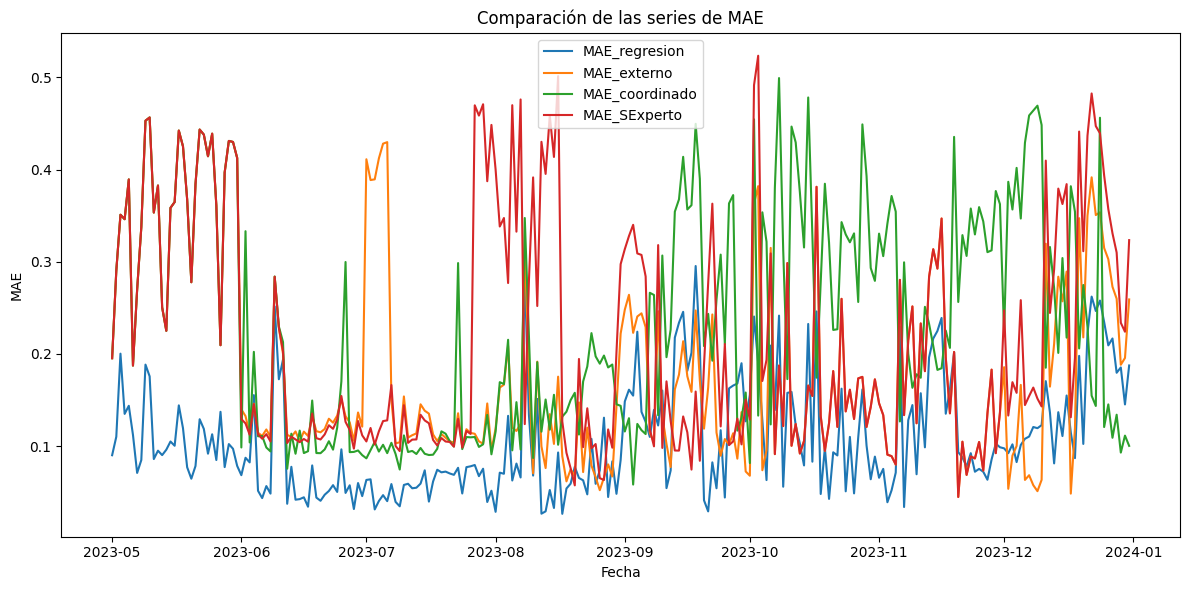

In [203]:


# Graficar las distintas series de MAE
plt.figure(figsize=(12, 6))
# Asumiendo que las columnas de MAE terminan con 'MAE'
for column in error_diario.columns:
    if column.startswith('MAE'):
        plt.plot(error_diario.index, error_diario[column], label=column)

plt.title('Comparación de las series de MAE')
plt.xlabel('Fecha')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()


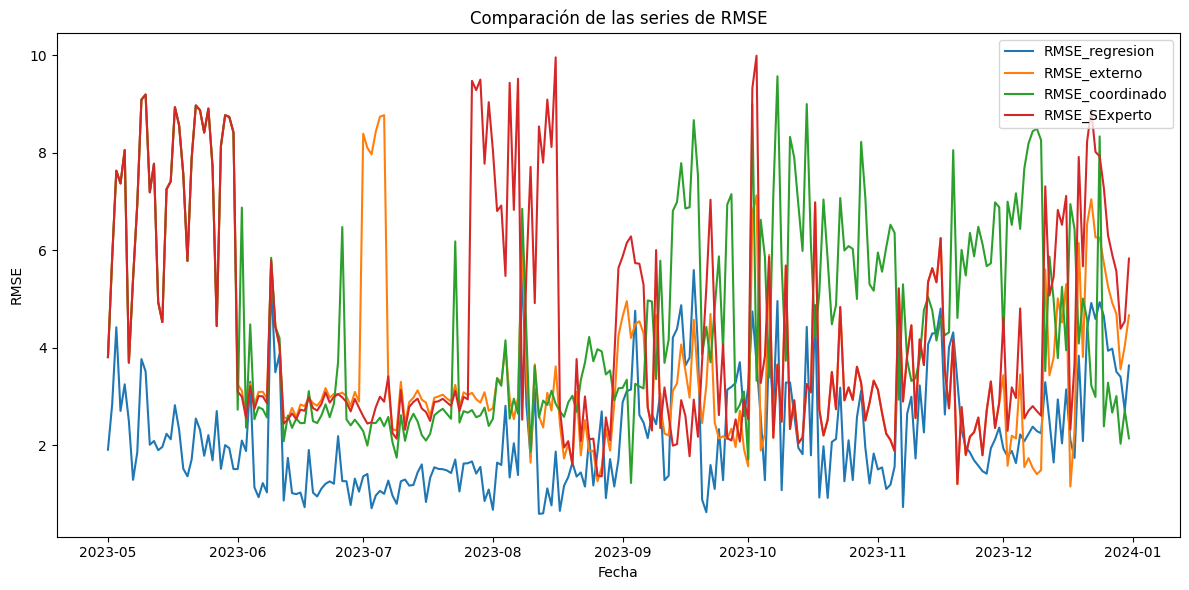

In [204]:
# Graficar las distintas series de RMSE
plt.figure(figsize=(12, 6))
# Asumiendo que las columnas de RMSE empiezan con 'RMSE'
for column in error_diario.columns:
    if column.startswith('RMSE'):
        plt.plot(error_diario.index, error_diario[column], label=column)

plt.title('Comparación de las series de RMSE')
plt.xlabel('Fecha')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.show()

## Error granularidad semanal

In [205]:
# Agrupar por semana y calcular el MAE semanal para cada tipo de error
error_semanal = pd.DataFrame()

error_semanal['MAE_regresion'] = (error.resample('W', on='Fecha')['MAE_regresion'].mean() / potencia_maxima)
error_semanal['RMSE_regresion'] = (error.resample('W', on='Fecha')['RMSE_regresion'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

error_semanal['MAE_externo'] = (error.resample('W', on='Fecha')['MAE_externo'].mean() / potencia_maxima)
error_semanal['RMSE_externo'] = (error.resample('W', on='Fecha')['RMSE_externo'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

error_semanal['MAE_coordinado'] = (error.resample('W', on='Fecha')['MAE_coordinado'].mean() / potencia_maxima)
error_semanal['RMSE_coordinado'] = (error.resample('W', on='Fecha')['RMSE_coordinado'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

# Calcular el MAE y RMSE para el Sistema Experto semanalmente
error['MAE_SExperto'] = np.abs(error['err_SExperto'])
error['RMSE_SExperto'] = error['err_SExperto'] ** 2
error_semanal['MAE_SExperto'] = (error.resample('W', on='Fecha')['MAE_SExperto'].mean() / potencia_maxima)
error_semanal['RMSE_SExperto'] = (error.resample('W', on='Fecha')['RMSE_SExperto'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

# Asegúrate de que 'potencia_maxima' es un escalar si es constante para todo el período o una serie con índices de fecha si varía a lo largo del tiempo.
# Si 'potencia_maxima' varía, deberías hacer un resample de esa serie también y usar el valor semanal correspondiente para cada cálculo.

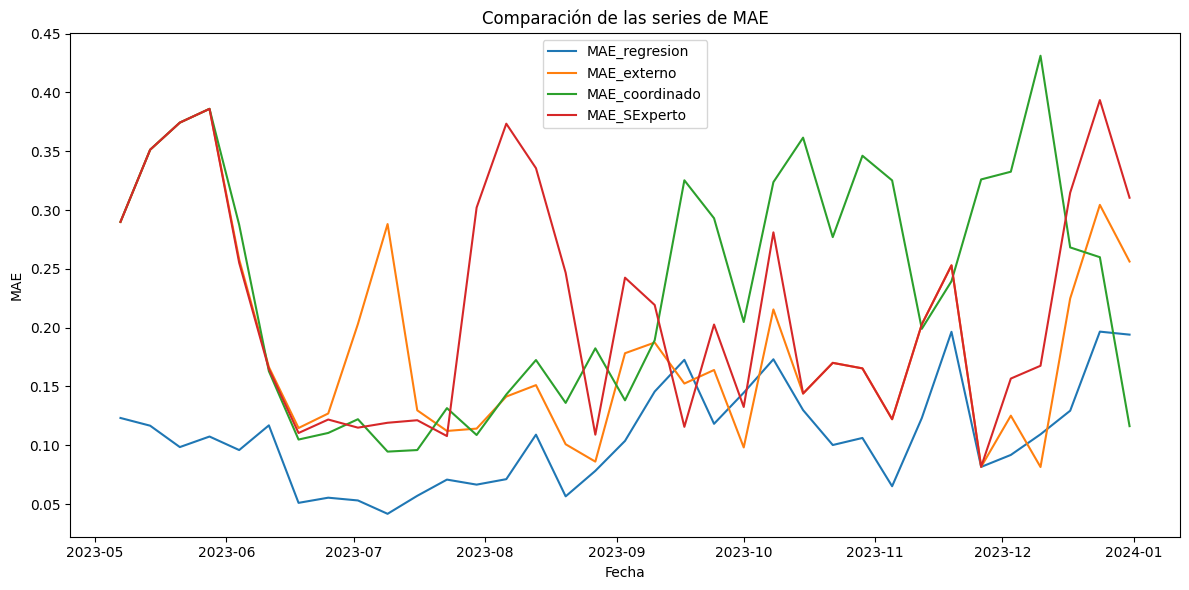

In [206]:

# Graficar las distintas series de MAE
plt.figure(figsize=(12, 6))
# Asumiendo que las columnas de MAE terminan con 'MAE'
for column in error_semanal.columns:
    if column.startswith('MAE'):
        plt.plot(error_semanal.index, error_semanal[column], label=column)

plt.title('Comparación de las series de MAE')
plt.xlabel('Fecha')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

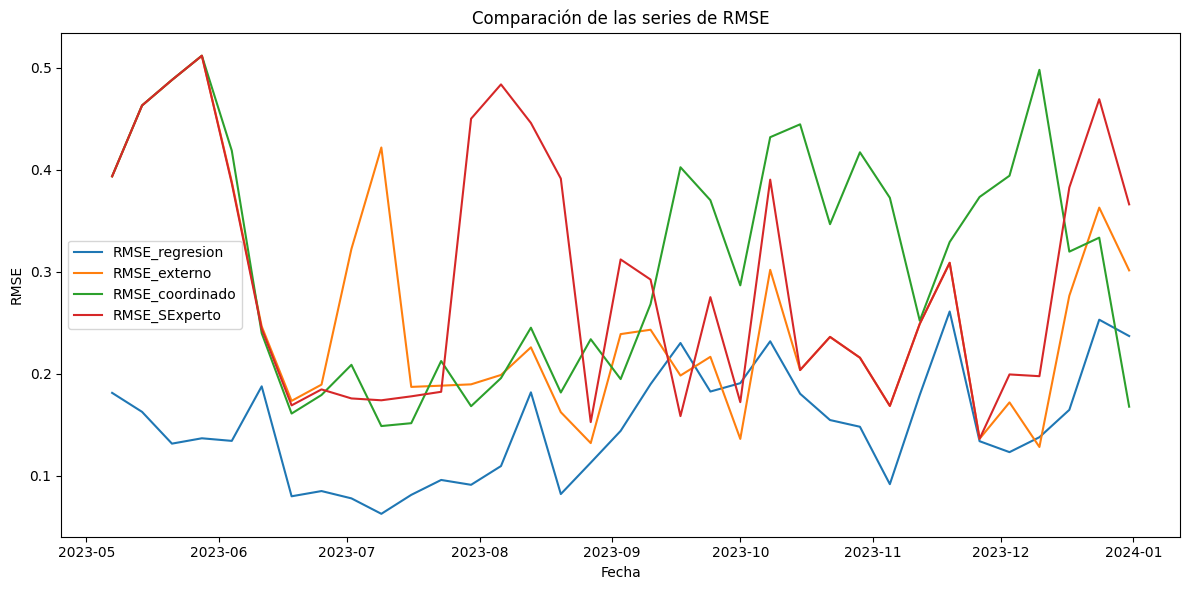

In [207]:
# Graficar las distintas series de RMSE
plt.figure(figsize=(12, 6))
# Asumiendo que las columnas de RMSE empiezan con 'RMSE'
for column in error_semanal.columns:
    if column.startswith('RMSE'):
        plt.plot(error_semanal.index, error_semanal[column], label=column)

plt.title('Comparación de las series de RMSE')
plt.xlabel('Fecha')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.show()

## Error granularidad mensual

In [208]:
# Agrupar por mes y calcular el MAE mensual para cada tipo de error
error_mensual = pd.DataFrame()

error_mensual['MAE_regresion'] = (error.resample('M', on='Fecha')['MAE_regresion'].mean() / potencia_maxima)
error_mensual['RMSE_regresion'] = (error.resample('M', on='Fecha')['RMSE_regresion'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

error_mensual['MAE_externo'] = (error.resample('M', on='Fecha')['MAE_externo'].mean() / potencia_maxima)
error_mensual['RMSE_externo'] = (error.resample('M', on='Fecha')['RMSE_externo'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

error_mensual['MAE_coordinado'] = (error.resample('M', on='Fecha')['MAE_coordinado'].mean() / potencia_maxima)
error_mensual['RMSE_coordinado'] = (error.resample('M', on='Fecha')['RMSE_coordinado'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

# Calcular el MAE y RMSE para el Sistema Experto mensualmente
error['MAE_SExperto'] = np.abs(error['err_SExperto'])
error['RMSE_SExperto'] = error['err_SExperto'] ** 2
error_mensual['MAE_SExperto'] = (error.resample('M', on='Fecha')['MAE_SExperto'].mean() / potencia_maxima)
error_mensual['RMSE_SExperto'] = (error.resample('M', on='Fecha')['RMSE_SExperto'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)


C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_15268\3510918136.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  error_mensual['MAE_regresion'] = (error.resample('M', on='Fecha')['MAE_regresion'].mean() / potencia_maxima)
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_15268\3510918136.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  error_mensual['RMSE_regresion'] = (error.resample('M', on='Fecha')['RMSE_regresion'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_15268\3510918136.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  error_mensual['MAE_externo'] = (error.resample('M', on='Fecha')['MAE_externo'].mean() / potencia_maxima)
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_15268\3510918136.py:8: FutureWarning: 'M' is deprecated and will be removed in 

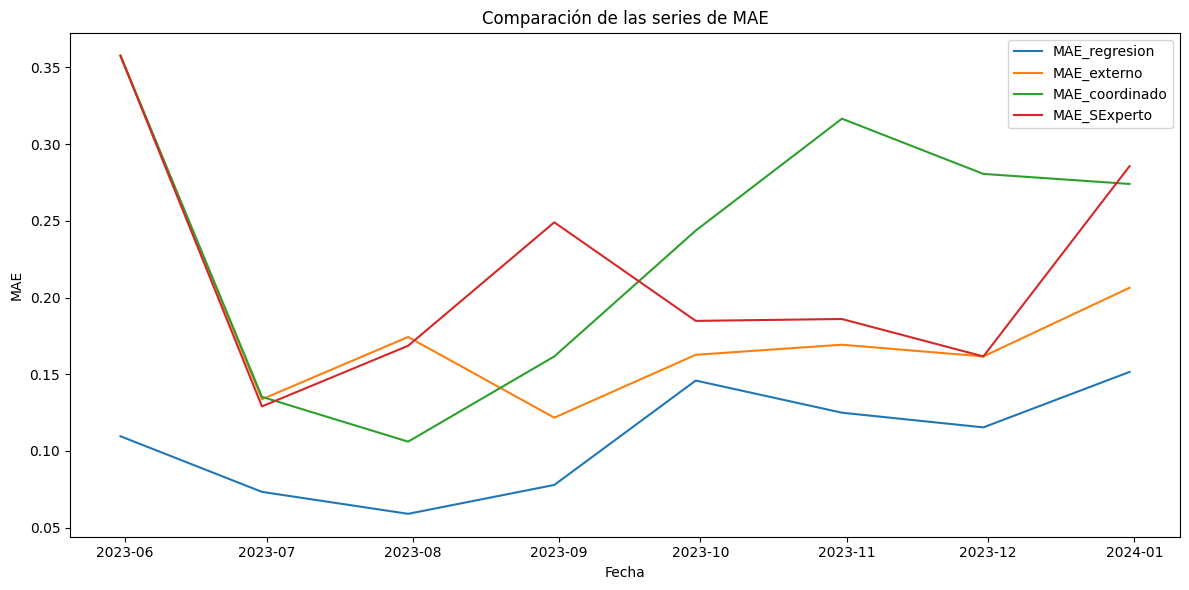

In [209]:
# Graficar las distintas series de MAE
plt.figure(figsize=(12, 6))
# Asumiendo que las columnas de MAE terminan con 'MAE'
for column in error_mensual.columns:
    if column.startswith('MAE'):
        plt.plot(error_mensual.index, error_mensual[column], label=column)

plt.title('Comparación de las series de MAE')
plt.xlabel('Fecha')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

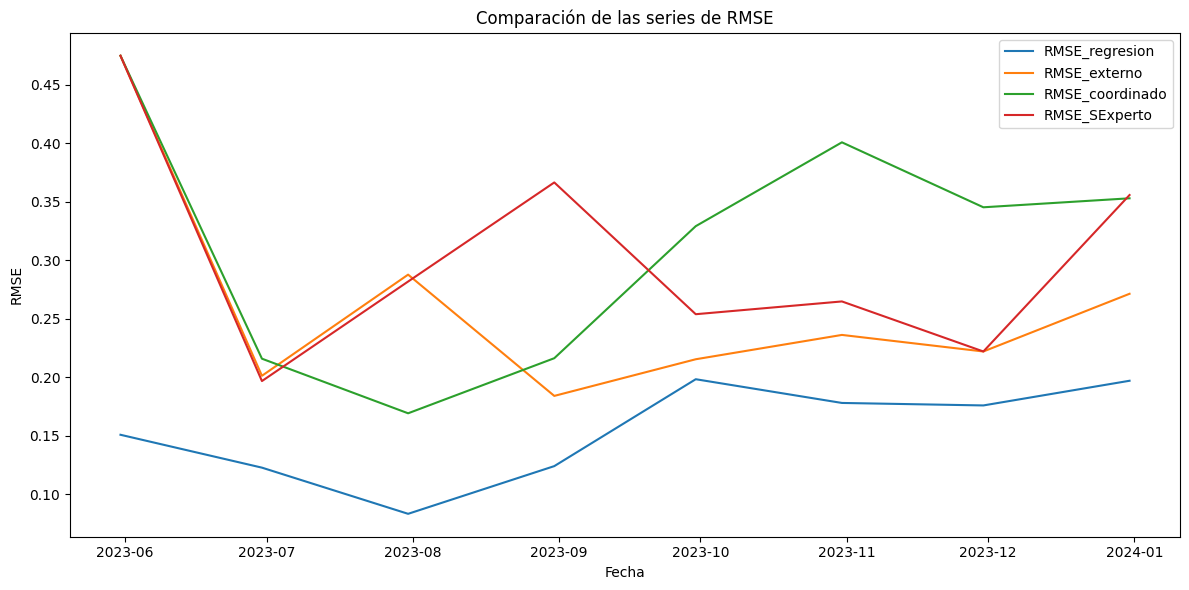

In [210]:
# Graficar las distintas series de RMSE
plt.figure(figsize=(12, 6))
# Asumiendo que las columnas de RMSE empiezan con 'RMSE'
for column in error_mensual.columns:
    if column.startswith('RMSE'):
        plt.plot(error_mensual.index, error_mensual[column], label=column)

plt.title('Comparación de las series de RMSE')
plt.xlabel('Fecha')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.show()

## Error total

In [211]:
# Calcular el MAE y RMSE totales para el período completo para cada tipo de error
error_total = pd.DataFrame(index=['Total'])

error_total['MAE_regresion'] = error['MAE_regresion'].mean() / potencia_maxima
error_total['RMSE_regresion'] = np.sqrt(error['RMSE_regresion'].mean()) / potencia_maxima

error_total['MAE_externo'] = error['MAE_externo'].mean() / potencia_maxima
error_total['RMSE_externo'] = np.sqrt(error['RMSE_externo'].mean()) / potencia_maxima

error_total['MAE_coordinado'] = error['MAE_coordinado'].mean() / potencia_maxima
error_total['RMSE_coordinado'] = np.sqrt(error['RMSE_coordinado'].mean()) / potencia_maxima

# Suponemos que la columna 'err_SExperto' representa el error para el Sistema Experto
error_total['MAE_SExperto'] = np.abs(error['err_SExperto']).mean() / potencia_maxima
error_total['RMSE_SExperto'] = np.sqrt((error['err_SExperto'] ** 2).mean()) / potencia_maxima

# Imprimir los errores totales
print(error_total)

       MAE_regresion  RMSE_regresion  MAE_externo  RMSE_externo  \
Total       0.107134        0.158428     0.186305        0.2763   

       MAE_coordinado  RMSE_coordinado  MAE_SExperto  RMSE_SExperto  
Total          0.2346         0.328194      0.215979       0.314833  


# Generación Consolidado

In [276]:
centrales = df_limpio['Nombre'].unique()[:]
# Crear un diccionario para almacenar las predicciones de cada central
consolidado= {}
for central in centrales:
    #definimos la central
    datos_central = df_limpio[df_limpio['Nombre']== central]
    
    
    #Definimas las variables
    Y = datos_central['Generacion_Potencial']
    dummies = pd.get_dummies(datos_central['Hora'], drop_first=True, prefix='h')
    dummies = dummies.astype(float)
    X = pd.concat([datos_central['Externo'],datos_central['Coordinado'], dummies],axis=1)
    X = sm.add_constant(X)
    
    # Definimos las interacciones 
    var_ind = ['Externo', 'Coordinado']
    for var in var_ind:
        for dummie in dummies.columns:
            nombre_interaccion = f'{var}-{dummie}'
            X[nombre_interaccion] = X[var] * X[dummie]
    parametros = {}
    # Definir parámetros específicos de la central
    horas_relevantes = datos_central['Hora'].unique()
    num_dias_entrenamiento = 120
    filas_por_dia = len(horas_relevantes)
    dias_totales = len(X) // filas_por_dia
    potencia_maxima = datos_central['Potencia_max_bruta'].max()
    parametros = {
        'horas_relevantes':horas_relevantes,
        'num_dias_entrenamiento':num_dias_entrenamiento,
        'filas_por_dia': filas_por_dia,
         'dias_totales': dias_totales,
         'potencia_maxima': potencia_maxima
    }
    
    # Inicializar DataFrames temporales para esta central
    predicciones_df = pd.DataFrame()
    parametros_df = pd.DataFrame()
    variables_prediccion_df = pd.DataFrame()
    
    # Iterar a través de los días, ajustando el modelo y realizando predicciones
    for dia in range(dias_totales - num_dias_entrenamiento):
        # Definir el conjunto de entrenamiento para la ventana actual
        inicio = dia * filas_por_dia
        fin = inicio + num_dias_entrenamiento * filas_por_dia
        X_train = X.iloc[inicio:fin]
        Y_train = Y.iloc[inicio:fin]

        # Ajustar el modelo
        modelo = sm.OLS(Y_train, X_train).fit()

        # Extraer y almacenar los parámetros estimados para la fecha actual
        parametros_actuales = modelo.params
        parametros_df = pd.concat([parametros_df, pd.DataFrame(parametros_actuales).T])

        # Realizar predicciones para el siguiente día
        X_test = X.iloc[fin:fin + filas_por_dia]
        predicciones = modelo.predict(X_test)
        # Aplicar el límite inferior y superior a las predicciones
        predicciones = np.maximum(predicciones, 0)  # Límite inferior, asegurando que la predicción no sea menor que 0
        predicciones = np.minimum(predicciones, potencia_maxima)  # Límite superior

        # Almacenar las predicciones
        predicciones_df = pd.concat([predicciones_df, predicciones])
        # Almacenar las variables utilizadas para la predicción del nuevo día
        variables_prediccion_df = pd.concat([variables_prediccion_df, X_test])

    # Almacenar los resultados en el diccionario, usando el nombre de la central como clave
    predicciones_df.rename(columns={0:'pred'},inplace=True)
    consolidado[central] = {
        'datos_central':datos_central,
        'parametros': parametros,
        'parametros_modelo': parametros_df.reset_index(drop=True),
        'predicciones': predicciones_df.reset_index(drop=True),
        'variables_prediccion': variables_prediccion_df.reset_index(drop=True)
    }
    
    # Opcional: Limpieza de variables para optimizar la memoria
    del X, X_train, X_test, Y, dummies, parametros_df, predicciones_df, variables_prediccion_df
    


In [241]:
consolidado.keys()

dict_keys(['PFV PAMPA CAMARONES', 'PFV ANDES SOLAR', 'PFV ATACAMA SOLAR II', 'PFV HUATACONDO', 'PFV TAMAYA SOLAR', 'PFV LA HUELLA', 'PFV BOLERO', 'PFV LA SILLA', 'PFV CARRERA PINTO', 'PFV FINIS TERRAE', 'PFV DIEGO DE ALMAGRO', 'PFV SAN ANDRES', 'PFV CHAÑARES', 'PFV JAVIERA', 'PFV LOS LOROS', 'PFV SAN PEDRO', 'PFV PUERTO SECO SOLAR', 'PFV PAMPA SOLAR NORTE', 'PFV LUZ DEL NORTE', 'PFV LALACKAMA', 'PFV NUEVO QUILLAGUA', 'PFV SOL DE LOS ANDES', 'PFV MALGARIDA', 'PFV LA CRUZ SOLAR', 'PFV URIBE SOLAR', 'PFV SOL DEL DESIERTO', 'PFV ALMEYDA', 'PFV SANTIAGO SOLAR', 'PFV DEL DESIERTO', 'PFV POZO ALMONTE SOLAR II', 'PFV DOÑA CARMEN SOLAR', 'PFV GRANJA SOLAR', 'PFV EL ROMERO', 'PFV CONEJO SOLAR', 'PFV LA HUAYCA II', 'PFV USYA', 'PFV EL PELICANO', 'PFV SOL DEL NORTE', 'PFV JAMA', 'PFV CERRO DOMINADOR', 'PFV LLANO DE LLAMPOS', 'PFV RIO ESCONDIDO', 'PFV QUILAPILUN', 'PFV MARIA ELENA', 'PFV POZO ALMONTE SOLAR III', 'PFV LALACKAMA II', 'PFV DE LOS ANDES', 'PFV EL AGUILA'])

In [287]:
central = 'PFV ATACAMA SOLAR II'
datos_central = consolidado[central]['datos_central']
parametros = consolidado[central]['parametros']
predicciones = consolidado[central]['predicciones']
dc245  = pd.DataFrame()
dc245 = datos_central.iloc[parametros['num_dias_entrenamiento']*parametros['filas_por_dia']:]
dc245.reset_index(inplace=True)
dc245['pred'] = predicciones['pred']
dc245['dia'] = dc245['Fecha'].dt.date
# Usar factorize() para crear los identificadores únicos
dc245['identificador'] = pd.factorize(dc245['dia'])[0]
dc245

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_15268\3150196682.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc245['pred'] = predicciones['pred']
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_15268\3150196682.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc245['dia'] = dc245['Fecha'].dt.date
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_15268\3150196682.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,index,Fecha,Nombre,Externo,Coordinado,SExperto,Potencia_max_bruta,Generacion_Potencial,Hora,pred,dia,identificador
0,138305,2023-05-01 01:00:00,PFV ATACAMA SOLAR II,0.0,0.00,0.000,170.65,0.00,1,0.000000e+00,2023-05-01,0
1,138358,2023-05-01 02:00:00,PFV ATACAMA SOLAR II,0.0,0.00,0.000,170.65,0.00,2,0.000000e+00,2023-05-01,0
2,138419,2023-05-01 03:00:00,PFV ATACAMA SOLAR II,0.0,0.00,0.000,170.65,0.00,3,0.000000e+00,2023-05-01,0
3,138448,2023-05-01 04:00:00,PFV ATACAMA SOLAR II,0.0,0.00,0.000,170.65,0.00,4,0.000000e+00,2023-05-01,0
4,138526,2023-05-01 05:00:00,PFV ATACAMA SOLAR II,0.0,0.00,0.000,170.65,0.00,5,3.086597e-13,2023-05-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5385,420231,2023-12-31 18:00:00,PFV ATACAMA SOLAR II,101.4,86.51,91.086,170.65,90.88,18,1.000597e+02,2023-12-31,244
5386,420281,2023-12-31 19:00:00,PFV ATACAMA SOLAR II,41.0,31.02,34.069,170.65,90.99,19,8.414173e+01,2023-12-31,244
5387,420315,2023-12-31 20:00:00,PFV ATACAMA SOLAR II,0.7,0.08,0.270,170.65,90.96,20,1.100347e+02,2023-12-31,244
5388,420367,2023-12-31 21:00:00,PFV ATACAMA SOLAR II,0.0,0.00,0.000,170.65,3.50,21,4.224816e-01,2023-12-31,244


In [284]:
# Calculando el rango intercuartílico (IQR)
Q1 = dc245['pred'].quantile(0.25)
Q3 = dc245['pred'].quantile(0.75)
IQR = Q3 - Q1

# Definiendo los límites para considerar un dato como outlier
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificando los outliers
outliers = dc245[(dc245['pred'] < limite_inferior) | (dc245['pred'] > limite_superior)]
no_outliers = dc245[(dc245['pred'] >= limite_inferior) & (dc245['pred'] <= limite_superior)]

print("Outliers:")
print(outliers)
#print("\nDatos sin outliers:")
#print(no_outliers)

Outliers:
Empty DataFrame
Columns: [index, Fecha, Nombre, Externo, Coordinado, SExperto, Potencia_max_bruta, Generacion_Potencial, Hora, pred, dia, identificador]
Index: []
